# Milk Glycan Biosynthesis Analysis
- this Jupyter notebook is designed to be run in Google Colab, with the files in ./data being located in fp_in
- while running top to bottom is recommended, most subsections should be independently runnable

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install --upgrade scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
%matplotlib inline
import itertools
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
!pip install torch==1.13
import torch
import pickle
import copy
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from collections import Counter, defaultdict
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

fp_in = 'drive/My Drive/milk_glycans/data/'

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
!pip install torch-geometric==2.2.0

#as soon as glycowork releases its version 0.7, that will be the reference version for this notebook
#!pip install glycowork==0.7.0
!pip install git+https://github.com/BojarLab/glycowork.git@dev
import glycowork

# Biosynthetic Networks
- generates networks from a list of glycans, in which glycans that differ by one monosaccharide + linkage are connected with a labeled edge
- could be used to postulate biosynthetic pathways and intermediate structures that have not been observed yet

In [ ]:
#imports and dataset construction
from glycowork.motif.graph import glycan_to_nxGraph, compare_glycans, generate_graph_features, subgraph_isomorphism
from glycowork.motif.processing import get_lib
from glycowork.motif.annotate import get_terminal_structures
from glycowork.motif.analysis import get_pvals_motifs
from glycowork.glycan_data.loader import motif_list, unwrap, build_df_species

from glycowork.network.biosynthesis import construct_network, plot_network, export_network, highlight_network, trace_diamonds, find_diamonds
from glycowork.network.biosynthesis import network_alignment, infer_virtual_nodes, infer_network, retrieve_inferred_nodes, prune_network, evoprune_network
from glycowork.network.evolution import distance_from_embeddings, distance_from_metric, dendrogram_from_distance, check_conservation, jaccard, get_communities, calculate_distance_matrix
from glycowork.ml.inference import glycans_to_emb, get_lectin_preds
from glycowork.ml.train_test_split import hierarchy_filter, prepare_multilabel
from glycowork.ml.processing import split_data_to_train
from glycowork.ml.train_test_split import general_split
from glycowork.ml.models import prep_model
from glycowork.ml import model_training
from glycowork.ml import models

df_milk = pd.read_csv(fp_in+'TableS1.csv')
idx = [k for k in range(len(df_milk)) if '{' not in df_milk.target.values.tolist()[k]]
df_milk = df_milk.iloc[idx,:].reset_index(drop = True)
lib = sorted(set(get_lib(df_milk.target.values.tolist()) + get_lib(motif_list.motif.values.tolist())))

species_list = sorted(set(df_milk.Species.values.tolist()))

with open(fp_in + 'milk_networks_exhaustive', 'rb') as file:
  unpruned_networks = pickle.load(file)

## Example network construction and pruning

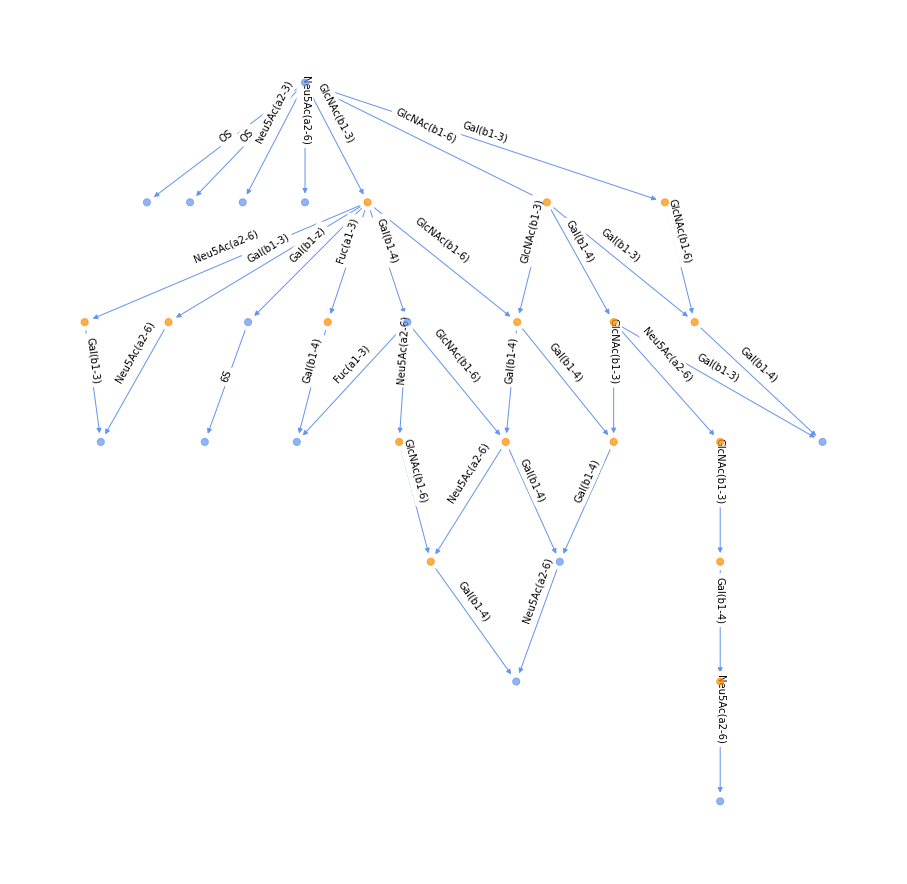

In [ ]:
#constructing biosynthetic network with buffalo milk glycans
df_buffalo = df_milk[df_milk.Species == 'Bubalus_bubalis'].reset_index(drop = True)
test_buffalo = construct_network(df_buffalo.target.values.tolist(), libr = lib)
plot_network(test_buffalo)

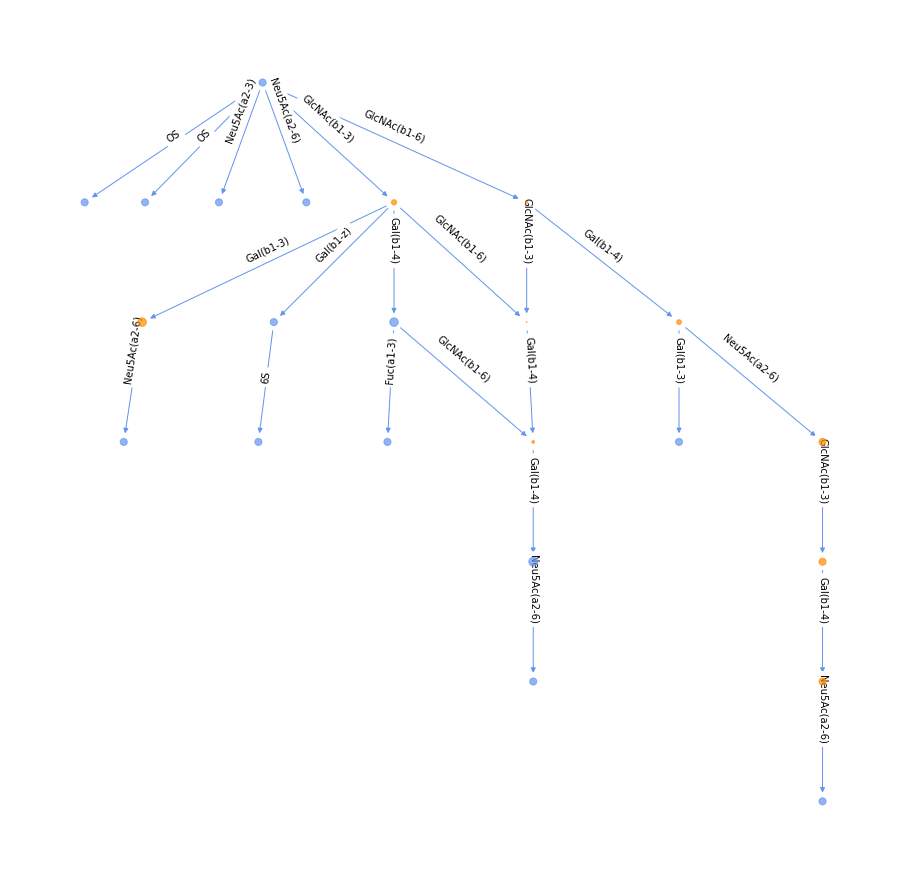

In [ ]:
#pruning buffalo network based on evolutionary information
test_buffalo2 = evoprune_network(test_buffalo, species_list, fp_out, libr = lib)
plot_network(test_buffalo2)

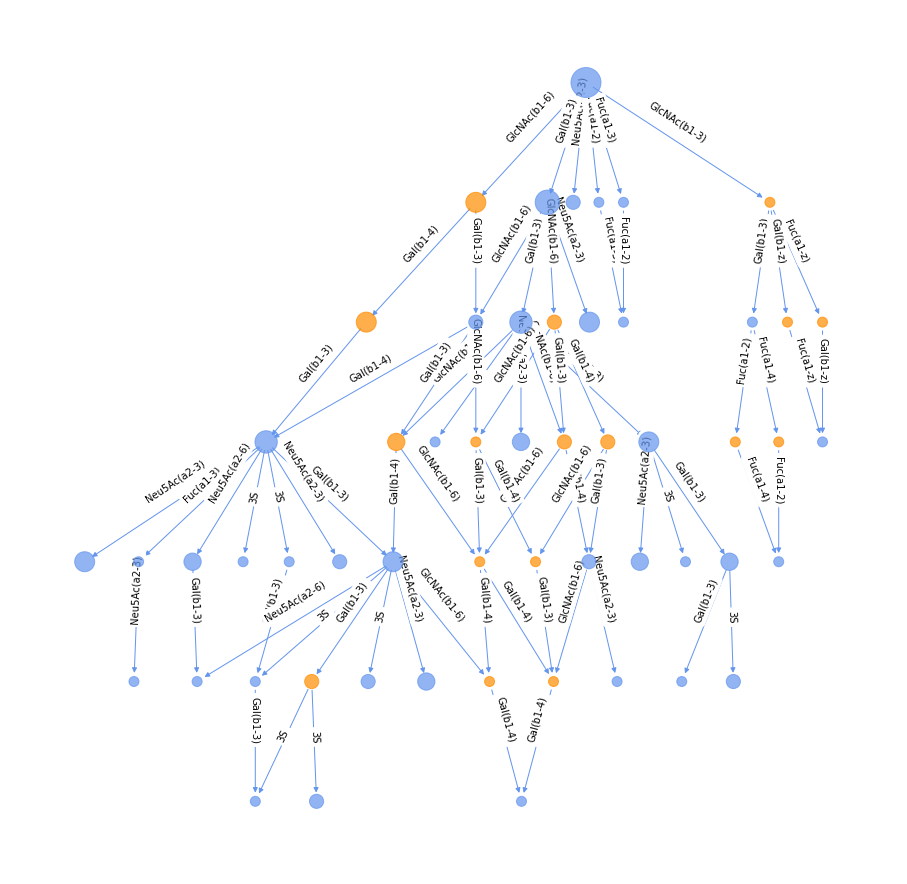

In [ ]:
#create a biosynthetic network of Diprotodontia milk glycans and scale nodes by how conserved each milk glycan is in that group
df_diproto = df_milk[df_milk.Order == "Diprotodontia"].reset_index(drop = True)
net_diproto = construct_network(list(set(df_diproto.target.values.tolist())), libr = lib)
net_diproto2 = evoprune_network(net_diproto, species_list, fp_out, libr = lib)
net_diproto2 = highlight_network(net_diproto2, highlight = 'conservation',
                               conservation_df = df_milk[df_milk.Order == 'Diprotodontia'],
                               filepath = fp_in)
plot_network(net_diproto2)

## Example of Oglycans/glycolipids

In [ ]:
###example of network generation with glycolipids
#glycolipids
mask = df_species.target.apply(lambda x: any(item in x for item in ['Glc1Cer', 'Gal1Cer']))
df_species = df_species[mask].reset_index(drop = True)
df_sheep = df_species[df_species.Species == 'Ovis_aries'].reset_index(drop = True)
df_sheep

,target,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref
0,Gal(a1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)Glc1Cer,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/78708/
1,Gal(a1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(...,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/7504839/
2,Gal(a1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(...,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,
3,Gal(a1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(...,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,
4,Gal(a1-4)Gal(b1-4)Glc1Cer,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/7804001/
5,Gal(b1-3)GalNAc(b1-4)Gal(b1-4)Glc1Cer,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
6,Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(...,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/2022659/
7,Gal(b1-4)Glc1Cer,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
8,Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(...,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/78708/
9,Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(...,Ovis_aries,Ovis,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/27085416/


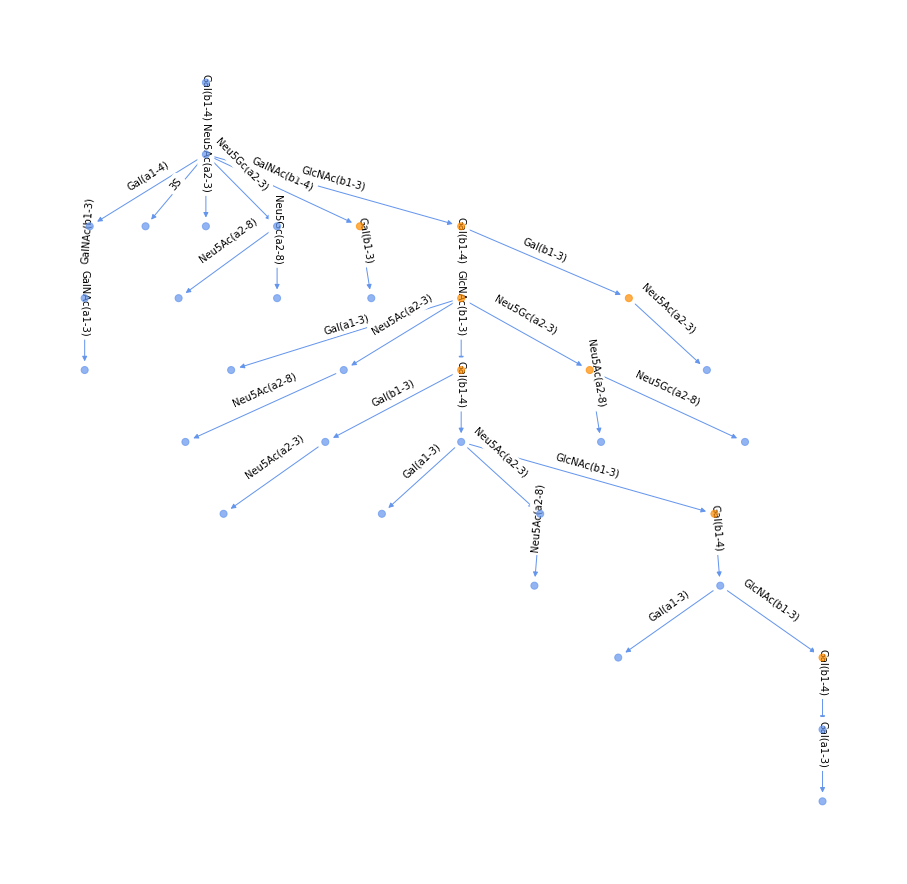

In [ ]:
#glycolipids
net_sheep = construct_network(df_sheep.target.values.tolist() + ['Glc1Cer'])
plot_network(net_sheep)

## Network statistics

In [ ]:
#calculate statistics of networks (note that the manuscript uses pruned networks for this)
feats = []
for k in species_list:
  try:
    feats.append(generate_graph_features(unpruned_networks[k], glycan_graph = False, libr = lib, label = k))
  except:
    pass
df_feat = pd.concat(feats, axis = 0)
rank = 'Order'
df_feat[rank] = [df_milk[rank].values.tolist()[df_milk.Species.values.tolist().index(k)] for k in df_feat.index.tolist()]
freq_species = [k for k in range(df_feat.shape[0]) if len(list(set(df_milk[df_milk[rank] == df_feat[rank].values.tolist()[k]].Species.values.tolist()))) > 5]
df_feat2 = df_feat.iloc[freq_species,:]
df_feat2

/usr/local/lib/python3.7/dist-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/usr/local/lib/python3.7/dist-packages/networkx/algorithms/assortativity/mixing.py:208: RuntimeWarning: invalid value encountered in true_divide
  a = a / a.sum()
/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1595: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/glycowork/motif/graph.py:479: RuntimeWarning: divide by zero encountered in log
  entropyStation = np.sum(distr*np.log(distr))
/usr/local/lib/python3.7/dist-packages/glycowork/motif/graph.py:479: RuntimeWarning: invalid value encountered in multiply
  entropyStation = np.sum(distr*np.log(distr))


,diameter,branching,nbrLeaves,avgDeg,varDeg,maxDeg,nbrDeg4,max_deg_leaves,mean_deg_leaves,deg_assort,...,secorderMin,secorderAvg,secorderVar,size_corona,size_core,nbr_node_types,egap,entropyStation,N,dens
Acinonyx_jubatus,NaN,1.0,5.0,1.250000,4.520833,8.0,1.0,7.0,7.0,-0.621195,...,NaN,NaN,NaN,2.0,6.0,12.0,-9.662289e-03,-2.025795,12.0,7.5
Addax_nasomaculatus,NaN,2.0,2.0,1.333333,4.222222,6.0,2.0,4.0,4.0,NaN,...,NaN,NaN,NaN,2.0,9.0,9.0,0.000000e+00,-1.886452,9.0,6.0
Aepyceros_melampus,NaN,4.0,11.0,1.281250,4.264648,11.0,3.0,15.0,15.0,-0.376405,...,NaN,NaN,NaN,2.0,15.0,32.0,-5.267400e-09,-3.061722,32.0,20.5
Ailuropoda_melanoleuca,NaN,1.0,2.0,1.333333,4.555556,6.0,1.0,4.0,4.0,NaN,...,NaN,NaN,NaN,2.0,6.0,6.0,-7.655399e-02,-1.640386,6.0,4.0
Alcelaphus_buselaphus,NaN,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,1.0,1.0,1.0,0.000000e+00,0.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ursus_arctos_lasiotus,NaN,1.0,14.0,1.230769,1.331361,6.0,1.0,17.0,17.0,-0.360844,...,NaN,NaN,NaN,6.0,18.0,26.0,-1.504641e-01,-2.996993,26.0,16.0
Ursus_arctos_yesoensis,NaN,1.0,13.0,1.250000,1.330357,6.0,1.0,16.0,16.0,-0.420942,...,NaN,NaN,NaN,8.0,25.0,28.0,-6.873229e-02,-3.104564,28.0,17.5
Ursus_maritimus,NaN,6.0,14.0,1.657143,2.796735,8.0,4.0,26.0,26.0,-0.476375,...,NaN,NaN,NaN,2.0,12.0,35.0,-6.943117e-02,-3.075042,35.0,29.0
Ursus_thibetanus_japonicus,NaN,11.0,30.0,1.555556,1.770723,8.0,5.0,45.0,45.0,-0.318802,...,NaN,NaN,NaN,4.0,24.0,63.0,-7.732859e-02,-3.858376,63.0,49.0


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 39.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 45.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


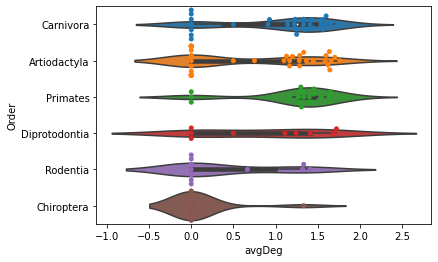

In [ ]:
#3, 5, 9 are the metrics shown in the manuscript
k = 3
sns.violinplot(y = rank, x = df_feat2.columns.values.tolist()[k],
            data = df_feat2)
sns.swarmplot(y = rank, x = df_feat2.columns.values.tolist()[k],
            data = df_feat2)
#plt.savefig(fp_out+'avg_degree.svg', format='svg',dpi=300,bbox_inches='tight')

## Analysis of virtual nodes

In [ ]:
#analysis of whether virtual nodes are enriched in particular terminal motifs; note that this analysis was done on pruned networks in the manuscript
def pad_dict_list(dict_list, padel):
    lmax = 0
    for lname in dict_list.keys():
        lmax = max(lmax, len(dict_list[lname]))
    for lname in dict_list.keys():
        ll = len(dict_list[lname])
        if  ll < lmax:
            dict_list[lname] += [padel] * (lmax - ll)
    return dict_list

all_networks = [unpruned_networks[k] for k in species_list]
all_nodes = list(the_all_network.nodes())
all_dict = defaultdict(list)
for network in all_networks:
  for key,value in list(nx.get_node_attributes(network, 'virtual').items()):
    all_dict[key].append(value)
all_dict = pad_dict_list(all_dict, np.nan)
df_virtual = pd.DataFrame(all_dict)
df_virtual

,Gal(b1-6)Gal(b1-4)Glc-ol,Gal(a1-3)Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(b1-4)Glc3S-ol,Neu5Ac(a2-8)Neu5Ac(a2-3)Gal(b1-4)Glc-ol,Gal(b1-4)Glc-ol,GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-3)[GlcNAc(b1-6)]Gal(b1-4)Glc-ol,GlcNAc(b1-3)[GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-6)Gal(b1-4)Glc-ol,GlcNAc(b1-6)Gal(b1-4)Glc-ol,GlcNAc(b1-3)Gal(b1-4)Glc-ol,Neu5Ac(a2-3)Gal(b1-4)Glc-ol,Neu5Gc(a2-6)Gal(b1-4)GlcNAc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc-ol,Neu5Gc(a2-3)Gal(b1-4)Glc-ol,Neu5Gc(a2-6)Gal(b1-4)Glc-ol,Neu5Gc(a2-8)Neu5Gc(a2-3)Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc-ol,Gal(b1-4)GlcOS-ol,GalOS(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)Glc-ol,GalNAc(a1-3)GlcNAc(b1-3)Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-3)Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)Glc-ol,Gal(b1-3)[Neu5Ac(a2-6)]GlcNAc(b1-3)Gal(b1-4)Glc-ol,Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,GalNAc(a1-3)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Neu5Ac(a2-6)GlcNAc(b1-3)Gal(b1-4)Glc-ol,Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)Glc-ol,Gal(b1-3)Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)[GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)Gal(b1-4)Glc-ol,Gal(b1-3)GlcNAc(b1-3)[GlcNAc(b1-6)]Gal(b1-4)Glc-ol,GalNAc(a1-3)GlcNAc(b1-3)[GlcNAc(b1-6)]Gal(b1-4)Glc-ol,...,Gal(b1-4)GlcNAc(b1-3)[Gal(a1-3)[Fuc(a1-2)]Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)[Fuc(a1-3)]Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)[Gal(a1-3)[Fuc(a1-2)]Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)[Fuc(a1-3)]Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)[Fuc(a1-3)]Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-3)[Gal(a1-3)[Fuc(a1-2)]Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)Gal(b1-4)Glc-ol,GlcNAc(b1-3)[Gal(a1-3)[Fuc(a1-2)]Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)[Fuc(a1-3)]Gal(b1-4)Glc-ol,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)Gal(b1-4)Glc-ol,GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)[Fuc(a1-3)]Gal(b1-4)Glc-ol,Gal(b1-4)GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)Gal(b1-4)Glc-ol,GlcNAc(b1-3)[Gal(a1-3)[Fuc(a1-2)]Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)Gal(b1-4)Glc-ol,Gal(a1-3)Gal(b1-4)Fuc(a1-3)GlcNAc(b1-6)[Fuc(a1-3)]Gal(b1-4)Glc-ol,GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-6)Gal(b1-4)Glc-ol,Gal(a1-3)Gal(b1-4)Fuc(a1-3)GlcNAc(b1-6)Gal(b1-4)Glc-ol,Gal(b1-4)Fuc(a1-3)GlcNAc(b1-6)[Fuc(a1-3)]Gal(b1-4)Glc-ol,Gal(b1-4)Fuc(a1-3)GlcNAc(b1-6)Gal(b1-4)Glc-ol,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(a1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(a1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Fuc(a1-3)GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Fuc(a1-3)GlcNAc(b1-3)[Gal(a1-3)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc-ol,Gal(a1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]Glc-ol,Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)Glc-ol,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)[Fuc(a1-3)]Glc-ol,Gal(a1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]Glc-ol,Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)Glc-ol,Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)[Gal(a1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)]Gal(b1-4)Glc-ol,Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Gal(

In [ ]:
df_virtual2 = df_virtual.dropna(thresh = 10, axis = 1)
df_virtual2 = df_virtual2.melt().dropna().reset_index(drop = True)
df_virtual2.value = df_virtual2.value.astype('category')
df_virtual3 = df_virtual2[["variable", "value"]].value_counts(sort = False).reset_index()
df_virtual3.columns = ['glycan', 'virtual', 'occurrences']

In [ ]:
#freq_virtual is the proportion of how often a node is seen as virtual in a network
df_virtual3.sort_values(by = 'freq_virtual', inplace = True, ascending = False)
sns.barplot(y = 'glycan', x = 'freq_virtual', data = df_virtual3)

In [ ]:
df_virtual = pd.read_csv(fp_in + 'TableS2.csv')
df_virtual['terminal'] = [get_terminal_structures(k, libr = lib) for k in df_virtual.target.values.tolist()]
df_virtual = df_virtual.explode('terminal').reset_index(drop = True)
df_virtual

,target,Species,virtual,terminal
0,Gal(b1-4)Glc-ol,Stenella_coeruleoalba,0,Gal(b1-4)
1,Gal(b1-4)Glc-ol,Saimiri_boliviensis,0,Gal(b1-4)
2,Neu5Ac(a2-3)Gal(b1-4)Glc-ol,Saimiri_boliviensis,0,Neu5Ac(a2-3)
3,Neu5Ac(a2-6)Gal(b1-4)Glc-ol,Saimiri_boliviensis,0,Neu5Ac(a2-6)
4,Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)[Fuc(a1-3)]Glc-ol,Tachyglossus_aculeatus,0,Fuc(a1-2)
...,...,...,...,...
6213,GlcNAc(b1-6)Gal(b1-4)Glc-ol,Panthera_leo,1,GlcNAc(b1-6)
6214,Fuc(a1-3)GlcNAc(b1-6)Gal(b1-4)Glc-ol,Panthera_leo,1,Fuc(a1-3)
6215,Gal(b1-4)Glc-ol,Pteropus_pumilus,0,Gal(b1-4)
6216,Gal(b1-4)Glc-ol,Rousettus_aegyptiacus,0,Gal(b1-4)


In [ ]:
#enriched in virtual nodes
thresh = 0.5
motif_list = list(sorted(list(set(df_virtual.terminal.values.tolist()))))
freq_motifs = [k for k in motif_list if df_virtual.terminal.values.tolist().count(k) > 5]
ttests = []
for motif in freq_motifs:
  pool = df_virtual[df_virtual.terminal == motif].virtual.values.tolist()
  ttests.append(ttest_ind(pool, [thresh]*len(pool), alternative = 'greater', equal_var = False)[1])
ttests_corr = multipletests(ttests, method = 'hs')[1].tolist()
out = pd.DataFrame(list(zip(freq_motifs, ttests, ttests_corr)))
out.columns = ['motif', 'pval', 'corr_pval']
out.dropna(inplace = True)
out[out.corr_pval < 0.05]

In [ ]:
#enriched in observed nodes
thresh = 0.5
motif_list = list(sorted(list(set(df_virtual.terminal.values.tolist()))))
freq_motifs = [k for k in motif_list if df_virtual.terminal.values.tolist().count(k) > 5]
ttests = []
for motif in freq_motifs:
  pool = df_virtual[df_virtual.terminal == motif].virtual.values.tolist()
  ttests.append(ttest_ind(pool, [thresh]*len(pool), alternative = 'less', equal_var = False)[1])
ttests_corr = multipletests(ttests, method = 'hs')[1].tolist()
out = pd.DataFrame(list(zip(freq_motifs, ttests, ttests_corr)))
out.columns = ['motif', 'pval', 'corr_pval']
out.dropna(inplace=True)
out[out.corr_pval < 0.05]

## Virtual hubs

In [ ]:
#testing the hypothesis that virtual nodes are more connected on average than observed nodes; note that this is done on pruned networks in the manuscript
collecty = []
for net in list(unpruned_networks.values()):
  node_state = list(nx.get_node_attributes(net, 'virtual').values())
  degree_state = list(net.degree())
  degree_state = [k[1] for k in degree_state]
  in_degree_state = list(net.in_degree())
  in_degree_state = [k[1] for k in in_degree_state]
  collecty.append(list(zip(node_state, degree_state, in_degree_state)))
collecty = unwrap(collecty)
collecty = [k for k in collecty if k[2]>0]
collecty = [k for k in collecty if k[1]>1]

In [ ]:
virtuals = [k[1] for k in collecty if k[0] == 1]
reals = [k[1] for k in collecty if k[0] == 0]
ttest_ind(virtuals, reals, alternative = 'greater', equal_var = False)[1]

1.7475297447732555e-07

Text(0.5, 1.0, 'degree_1.7475297447732555e-07')

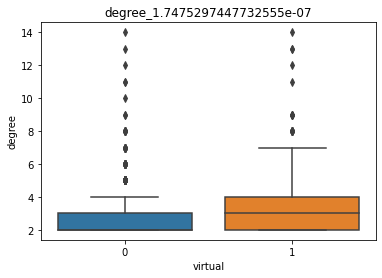

In [ ]:
temp = pd.DataFrame(collecty)
temp.columns = ['virtual', 'degree', 'in_degree']
ax = sns.boxplot(x="virtual", y = 'degree', data = temp)
plt.title('p = ' + str(1.7475297447732555e-07))

## Path dependence of reactions

In [ ]:
###path dependence of biosynthetic reactions
out = {}
for spec in species_list:
  spec_net = unpruned_network[spec]
  df_out = trace_diamonds(spec_net, species_list, net_dic, libr = lib)
  spec_net = highlight_network(spec_net, highlight = 'abundance', abundance_df = df_out, intensity_col = 'probability')
  temp = find_diamonds(spec_net)
  for d in temp:
    if len(d)>0:
      try:
        first = spec_net.get_edge_data(d[1], d[2])['diffs']
        second = spec_net.get_edge_data(d[2], d[3])['diffs']
        abundance1 = nx.get_node_attributes(spec_net, 'abundance')[d[2]]
        if first+'_'+second in list(out.keys()):
          out[first+'_'+second] = out[first+'_'+second] + [abundance1]
        else:
          out[first+'_'+second] = [abundance1]
        third = spec_net.get_edge_data(d[1], d[4])['diffs']
        fourth = spec_net.get_edge_data(d[4], d[3])['diffs']
        abundance2 = nx.get_node_attributes(spec_net, 'abundance')[d[4]]
        if third+'_'+fourth in list(out.keys()):
          out[third+'_'+fourth] = out[third+'_'+fourth] + [abundance2]
        else:
          out[third+'_'+fourth] = [abundance2]
      except:
        pass
out

In [ ]:
out2 = copy.deepcopy(out)
for k in range(len(out2)):
  out2[list(out2.keys())[k]] = np.mean(out2[list(out2.keys())[k]])
pool = sorted(set(unwrap([k.split('_') for k in list(out2.keys())])))

In [ ]:
#reaction pairs with path dependence
high_diffs = []
for a in pool:
  for b in pool:
    if a != b:
      first = a+'_'+b
      second = b+'_'+a
      if (first in list(out2.keys())) and (second in list(out2.keys())):
        #filter for min difference 30, multiple glycan contexts, and not adding things multiple times
        if (abs(out2[first]-out2[second]))>15 and len(out[first]) > 2 and all([second not in j for j in high_diffs]):
          for f in range(len(out[first])):
            high_diffs.append([first, 'forward', out[first][f]])
          for b in range(len(out[second])):
            high_diffs.append([first, 'reverse', out[second][b]])

temp = pd.DataFrame(high_diffs)
temp.columns = ['additions', 'order', 'probability']
temp = temp[~temp.additions.str.startswith('4Ac')].reset_index(drop=True)
sig_additions = []
for k in list(set(temp.additions.values.tolist())):
  part = temp[temp.additions == k]
  stat, p = ttest_ind(part[part.order =='forward'].probability,
                part[part.order =='reverse'].probability,
                equal_var = False)
  if p<0.05:
    sig_additions.append(k)
temp = temp[temp.additions.isin(sig_additions)].reset_index(drop=True)
temp

In [ ]:
#reaction pairs without path dependence
low_diffs = []
for a in pool:
  for b in pool:
    if a != b:
      first = a+'_'+b
      second = b+'_'+a
      if (first in list(out2.keys())) and (second in list(out2.keys())):
        if (0<abs(out2[first]-out2[second])<15) and len(out[first]) > 1 and all([second not in j for j in low_diffs]):
          for f in range(len(out[first])):
            low_diffs.append([first, 'forward', out[first][f]])
          for b in range(len(out[second])):
            low_diffs.append([first, 'reverse', out[second][b]])

temp2 = pd.DataFrame(low_diffs)
temp2.columns = ['additions', 'order', 'probability']
nonsig_additions = []
for k in list(set(temp2.additions.values.tolist())):
  part = temp2[temp2.additions == k]
  stat, p = ttest_ind(part[part.order =='forward'].probability,
                part[part.order =='reverse'].probability,
                equal_var = False)
  if p>0.05:
    nonsig_additions.append(k)
temp2 = temp2[temp2.additions.isin(nonsig_additions)].reset_index(drop=True)
temp2

In [ ]:
sns.boxplot(x = 'additions', y = 'probability', hue = 'order', data = temp)
sns.despine(left = True, bottom = True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation = 90)
plt.tight_layout()

In [ ]:
for k in list(set(temp.additions.values.tolist())):
  part = temp[temp.additions == k]
  stat, p = ttest_ind(part[part.order =='forward'].probability,
                part[part.order =='reverse'].probability,
                equal_var = False)
  print(p)

In [ ]:
sns.boxplot(x = 'additions', y = 'probability', hue = 'order', data = temp2)
sns.despine(left = True, bottom = True)
plt.legend(bbox_to_anchor = (1.1, 1.05))
plt.xticks(rotation = 90)
plt.tight_layout()

## Maximum-likelihood network

In [ ]:
#further prune networks by choosing reaction paths that are significantly more likely, given path dependence

def maximize_likelihood(network, reaction_dict, thresh = 0.01):
  #extract diamonds from pruned network
  diamonds = find_diamonds(network)
  print(len(diamonds))
  #subset diamonds with reactions in reaction_dict
  diamonds = [k for k in diamonds if (k[1],k[2]) in network.edges() and (k[2],k[3]) in network.edges() and (k[1],k[4]) in network.edges() and (k[4],k[3]) in network.edges()]
  diamonds = [k for k in diamonds if network.get_edge_data(k[1], k[2])['diffs']+'_'+network.get_edge_data(k[2], k[3])['diffs'] in reaction_dict.keys()]
  #choose a path for those with sig difference
  to_cut = []
  for d in diamonds:
    alt_a = reaction_dict[network.get_edge_data(d[1], d[2])['diffs']+'_'+network.get_edge_data(d[2], d[3])['diffs']]
    alt_b = reaction_dict[network.get_edge_data(d[1], d[4])['diffs']+'_'+network.get_edge_data(d[4], d[3])['diffs']]
    stat, p = ttest_ind(alt_a, alt_b, equal_var = False, alternative = 'two-sided')
    if p < thresh:
      idx = [4,2][np.argmax([np.mean(alt_a), np.mean(alt_b)])]
      if nx.get_node_attributes(network, 'virtual')[d[idx]] == 1 and not any([network.in_degree[j] == 1 and len(j) > len(d[idx]) for j in network.neighbors(d[idx])]):
        to_cut.append(d[idx])
  #drop nodes in pruned network consequently
  network_out = copy.deepcopy(network)
  network_out.remove_nodes_from(to_cut)
  diamonds = find_diamonds(network_out)
  print(len(diamonds))
  return network_out

#given a pruned network and reaction path dependencies/preferences --> what is the absolute minimum high-confidence network we can do?
net_buffalo = unpruned_networks['Bubalus_bubalis']
#of type A_B : probability of A-then-B; out is the output of the first cell in "Path dependence of reactions"
reaction_dict = out
max_net = maximize_likelihood(net_buffalo, reaction_dict)

24
12


## Community detection

In [ ]:
#retrieve biosynthetic communities from the networks; note that this was done using maximum likelihood pruned networks in the manuscript

networks = [unpruned_networks[k].to_undirected() for k in species_list]
comms = get_communities(networks, label_list = species_list)
comms = {k:v for k,v in comms.items() if v != ['Gal(b1-4)Glc-ol']}
dm = calculate_distance_matrix(comms, jaccard)
idx = [k for k in range(len(dm)) if np.mean(dm.iloc[:,k].values.tolist()) < 0.96]
dm2 = dm.iloc[idx, idx].reset_index(drop = True)
sns.clustermap(dm2)

,0_Acinonyx_jubatus,1_Acinonyx_jubatus,2_Acinonyx_jubatus,0_Addax_nasomaculatus,1_Addax_nasomaculatus,2_Addax_nasomaculatus,0_Aepyceros_melampus,1_Aepyceros_melampus,2_Aepyceros_melampus,3_Aepyceros_melampus,...,0_Ursus_thibetanus_japonicus,1_Ursus_thibetanus_japonicus,2_Ursus_thibetanus_japonicus,3_Ursus_thibetanus_japonicus,4_Ursus_thibetanus_japonicus,5_Ursus_thibetanus_japonicus,0_Vombatus_ursinus,1_Vombatus_ursinus,2_Vombatus_ursinus,3_Vombatus_ursinus
0,0.000000,1.0,1.0,0.875000,1.0,1.0,0.923077,1.0,1.0,0.9,...,1.0,1.000,0.800000,1.0,0.923077,1.0,1.0,1.0,0.777778,1.0
1,1.000000,0.0,1.0,1.000000,1.0,1.0,1.000000,1.0,0.5,1.0,...,1.0,0.875,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0
2,1.000000,1.0,0.0,1.000000,0.0,1.0,0.777778,1.0,1.0,1.0,...,1.0,1.000,0.875000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0
3,0.875000,1.0,1.0,0.000000,1.0,1.0,0.818182,1.0,1.0,1.0,...,1.0,1.000,0.900000,1.0,1.000000,1.0,1.0,1.0,0.888889,1.0
4,1.000000,1.0,0.0,1.000000,0.0,1.0,0.777778,1.0,1.0,1.0,...,1.0,1.000,0.875000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,...,1.0,1.000,1.000000,1.0,1.000000,0.0,1.0,1.0,1.000000,1.0
384,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,...,1.0,1.000,1.000000,1.0,1.000000,1.0,0.0,1.0,1.000000,1.0
385,1.000000,1.0,1.0,1.000000,1.0,1.0,0.928571,1.0,1.0,1.0,...,1.0,1.000,1.000000,1.0,1.000000,1.0,1.0,0.0,1.000000,1.0
386,0.777778,1.0,1.0,0.888889,1.0,1.0,0.928571,1.0,1.0,0.8,...,1.0,1.000,0.916667,1.0,0.846154,1.0,1.0,1.0,0.000000,1.0


In [ ]:
clustering = DBSCAN(eps = 1, min_samples = 6).fit(dm)
cluster_labels = clustering.labels_
num_clusters = len(list(set(cluster_labels)))
print(num_clusters)

clusters = []
for k in list(set(cluster_labels)):
  if k>=0:
    idx = [m for m in range(len(cluster_labels)) if cluster_labels[m]==k]
    clusters.append([dm.columns.values.tolist()[m] for m in idx])

cluster_glycans = []
for c in clusters:
  glycans = list(set(unwrap([comms[m] for m in c])))
  cluster_glycans.append(glycans)
cluster_glycans

In [ ]:
#enrichment of motifs in conserved biosynthetic modules; note that this also included virtual nodes in the analysis done in the manuscript

motif = 'GlcNAc(b1-3)Gal(b1-4)Glc-ol'
motif2 = 'GlcNAc(b1-3)Gal(b1-4)GlcNAc-ol'
df_milk['community'] = [1 if subgraph_isomorphism(k, motif, libr = lib) or subgraph_isomorphism(k, motif2, libr = lib) else 0 for k in df_virtual.target.values.tolist()]
temp = get_pvals_motifs(df_milk, glycan_col_name = 'target', label_col_name = 'community', thresh = 0.5,
                 feature_set = ['exhaustive', 'known'])
temp[temp.corr_pval<0.05]

In [ ]:
#check distribution of GlcNAcb1-3 community in lactosamine-MOs versus GlcNAcb1-6 community
motif = 'GlcNAc(b1-3)Gal(b1-4)GlcNAc-ol'
temp = df_virtual[df_virtual.target.str.endswith('GlcNAc-ol')]
sum([1 if subgraph_isomorphism(k, motif, libr = lib) else 0 for k in temp.target.values.tolist()])/len(temp)

## Glycan conservation

In [ ]:
#note that this and other conservation analyses in the manuscript were done including the virtual nodes
marsupial = ['Dasyurus_maculatus', 'Dasyurus_viverrinus', 'Vombatus_ursinus', 'Phascolarctos_cinereus', 'Trichosurus_vulpecula',
             'Notamacropus_eugenii', 'Osphranter_rufus']
df_milk2 = copy.deepcopy(df_milk)
df_milk2.target = [k.replace('[','').replace(']','') for k in df_milk2.target.values.tolist()]
specs = [k for k in species_list if len(df_milk2[df_milk2.Species==k])>=50]
non_marsupial = [k for k in specs if k not in marsupial]

glycan = 'Gal(a1-3)Gal'
glycan = glycan.replace('[','').replace(']','')
marsupial = [sum([k.count(glycan) for k in df_virtual[df_virtual.Species == spec].target.values.tolist()]) for spec in marsupial]
non_marsupial = [sum([k.count(glycan) for k in df_virtual[df_virtual.Species == spec].target.values.tolist()]) for spec in non_marsupial]
temp = pd.DataFrame([marsupial+non_marsupial, ['marsupial']*len(marsupial)+['non_marsupial']*len(non_marsupial)]).T
temp.columns = ['motif_count', 'taxonomic_group']
print(ttest_ind(marsupial, non_marsupial, alternative = 'less', equal_var = True)[1])
sns.barplot(y = 'taxonomic_group', x = 'motif_count', data = temp, capsize = 0.3)

# ML / DL

In [ ]:
#code for training a species-level deep learning model to gain glycan representations for visualization
glycans, labels = prepare_multilabel(df_species, rank = 'Species')
train_x, val_x, train_y, val_y = general_split(glycans, labels, test_size = 0.2)
dataloaders = split_data_to_train(train_x, val_x, train_y, val_y, label_type = torch.float, drop_last = True, libr = lib2)
model = models.prep_model('SweetNet', len(labels[0]))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.001, mode = 'multilabel')
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 150, mode = 'multilabel')
model_ft = model_ft.cuda()

# Dendrograms based on milk oligosaccharides

In [ ]:
#note that this analysis in the manuscript was done including the virtual nodes
all_glycs = sorted(set(df_milk.target.values.tolist()))
df_emb = glycans_to_emb(all_glycs, model_ft)
tsne_emb = TSNE(random_state=42, init = 'pca', learning_rate = 'auto').fit_transform(df_emb)

fuc = ['Fuc' if 'Fuc' in k else '-' for k in all_glycs]
sia = ['Sia' if 'Neu' in k else '-' for k in all_glycs]
combo = ['FucSia' if all([('Fuc' in k), ('Neu' in k)]) else 'Fuc' if 'Fuc' in k else 'Sia' if 'Neu' in k else '-' for k in all_glycs]

plt.figure(figsize = (9, 7))
sns.scatterplot(x = tsne_emb[:,0], y = tsne_emb[:,1], alpha = 0.6,
                hue = combo, palette = ['tomato', 'deeppink', 'lightgrey', 'darkviolet'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Fucosylation')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [ ]:
#note that this analysis in the manuscript was done using maximum-likelihood pruned networks
species_list2 = [spec for spec in df_milk.Species.values.tolist() if df_milk.Species.values.tolist().count(spec)>5]
all_networks = [unpruned_networks[k] for k in species_list2]
all_dfs = df_milk[df_milk.Species.isin(species_list2)].reset_index(drop = True)
dm = distance_from_metric(all_dfs, all_networks)
dendrogram_from_distance(dm)